In [1]:
#!pip install tensorflow-gpu

In [2]:
#!nvidia-smi

In [4]:
#imports for model building
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

#transfer learning imports
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

#imports for image data deneration
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

#general imports
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [5]:
#resize all the image to this
image_size = [224, 224]

In [6]:
#train and validation path
train_path = "Dataset/train"
valid_path = "Dataset/valid"

In [7]:
#we will use imagenet weights
inception = InceptionV3(input_shape=image_size+[3], weights="imagenet", include_top=False)

In [8]:
#don't train existing weights
for layers in inception.layers:
    layers.trainable = False

In [9]:
#useful for getting number of output classes
folders = glob("Dataset/train/*")

In [10]:
len(folders)

10

In [11]:
#we need to flatten the last layer of inceptionv3
x = Flatten()(inception.output)

In [12]:
#add the final dense layer
prediction = Dense(len(folders), activation="softmax")(x)

In [13]:
#create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [14]:
#view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [15]:
#compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
#image data generation with ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255)

In [17]:
#data for training the model
train_set = train_datagen.flow_from_directory(train_path, target_size=(224, 224),
                                              batch_size=16, class_mode="categorical")

valid_set = valid_datagen.flow_from_directory(valid_path, target_size=(224, 224),
                                              batch_size=16, class_mode="categorical")

Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


In [18]:
#fit the model
r = model.fit(train_set, validation_data=valid_set, epochs=5,
                        steps_per_epoch=len(train_set), validation_steps=len(valid_set))

Epoch 1/5
1147/1147 [==============================] - 1601s 1s/step - loss: 4.1546 - accuracy: 0.6757 - val_loss: 3.0843 - val_accuracy: 0.7668
Epoch 2/5
1147/1147 [==============================] - 1383s 1s/step - loss: 3.4521 - accuracy: 0.7855 - val_loss: 3.4948 - val_accuracy: 0.7839
Epoch 3/5
1147/1147 [==============================] - 1358s 1s/step - loss: 3.4947 - accuracy: 0.8140 - val_loss: 4.7014 - val_accuracy: 0.7817
Epoch 4/5
1147/1147 [==============================] - 1343s 1s/step - loss: 3.1507 - accuracy: 0.8380 - val_loss: 3.5550 - val_accuracy: 0.8242
Epoch 5/5
1147/1147 [==============================] - 1356s 1s/step - loss: 2.8249 - accuracy: 0.8563 - val_loss: 4.8532 - val_accuracy: 0.7969


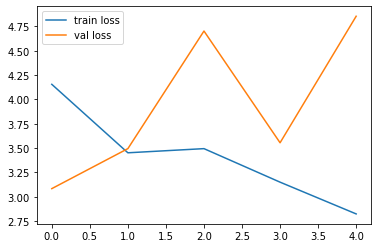

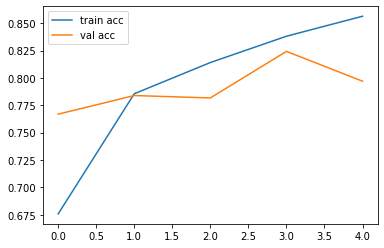

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
y_pred = model.predict(valid_set)
y_pred.shape

(4585, 10)

In [26]:
y_pred_int = np.argmax(y_pred, axis=1)
y_pred_int.shape

(4585,)

In [31]:
y_pred_int[0:50]

array([6, 1, 7, 5, 3, 4, 9, 2, 3, 3, 7, 6, 1, 7, 7, 5, 8, 8, 6, 8, 9, 7,
       9, 7, 8, 7, 5, 2, 9, 4, 9, 9, 0, 1, 1, 9, 6, 7, 3, 7, 9, 5, 0, 9,
       8, 6, 4, 0, 9, 2], dtype=int64)

In [28]:
#save the model as a h5 file
model.save("tomato_disease_inception.h5")

In [29]:
model=load_model('tomato_disease_inception.h5')

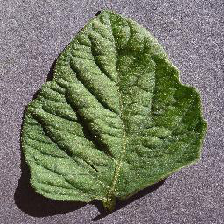

In [30]:
img=load_img('trial.jpg',target_size=(224,224))
img

In [31]:
x=img_to_array(img)
x.shape

(224, 224, 3)

In [32]:
x=x/255

In [33]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 224, 224, 3)

In [34]:
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [35]:
pred = model.predict(img_data)
pred

array([[1.9721503e-27, 5.8943463e-09, 1.0000000e+00, 5.2025934e-10,
        2.9782826e-11, 3.8991732e-13, 6.1035540e-17, 1.2980010e-24,
        7.9394598e-09, 8.1696438e-12]], dtype=float32)

In [36]:
pred_binary=np.argmax(pred, axis=1)
print(int(pred_binary))

2


In [37]:
def predict_tomato_disease(filepath):
    img=load_img(filepath, target_size=(224,224))
    x=img_to_array(img)
    x=x/255
    x=np.expand_dims(x,axis=0)
    img_data=preprocess_input(x)
    pred=model.predict(img_data)
    pred_binary=int(np.argmax(pred, axis=1))
    if pred_binary == 0:
        result = "Bacterial_spot"  
    if pred_binary == 1:
        result = "Early_blight"
    if pred_binary == 2:
        result = "Healthy"
    if pred_binary == 3:
        result = "Late_blight"
    if pred_binary == 4:
        result = "Leaf_Mold"
    if pred_binary == 5:
        result = "Septoria_leaf_spot"
    if pred_binary == 6:
        result = "Spider_mites Two-spotted_spider_mite"
    if pred_binary == 7:
        result = "Target_Spot"
    if pred_binary == 8:
        result = "Tomato_mosaic_virus"
    if pred_binary == 9:
        result = "Tomato_Yellow_Leaf_Curl_Virus" 
    
    return result

In [39]:
filepath = 'trial.jpg'
prediction = predict_tomato_disease(filepath)
prediction

'Healthy'